<a href="https://colab.research.google.com/github/19522531/CS114.L21/blob/main/Colab/b%C3%A0i%20to%C3%A1n%20Sarcasm%20detection%20in%20news%20headline/Train_issarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bài toán phát hiện mỉa mai, châm biếm dựa trên tiêu đề bài báo

## Xác định bối cảnh yêu cầu:

1. Xây dựng mô hình phân lớp nhị phân dự đoán một bài báo là châm biếm hay không.
2. Bài toán:
- Input: Là tiêu đề của bài báo
- Output: Châm biếm hay không.

## Thêm các thư viện cần thiết


In [127]:
#đọc, khám phá và tiền xử lý dữ liệu
import pandas as pd
import numpy as np
import matplotlib as plt
from tqdm import tqdm
import json
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag, word_tokenize

# Khám phá dữ liệu:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle # trộn lại dữ liệu

#cân bằng lại dữ liệu
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

#model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dropout
import os
import tensorflow as tf
from keras import layers
import keras

# Đánh giá mô hình
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
!nvidia-smi

In [128]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Đọc dữ liệu đã  thu thập 



In [130]:
def read_file_train(name):
  if name == "not_Satirical":
    ls = !ls "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Not_Satirical"
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Not_Satirical"
  else:
    ls = !ls "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Satirical"
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Satirical"
  lst = ls[0].split()
  lst_sentences = []
  lst_labels = []
  for i in lst:
    path_ = path +"/" + str(i)
    data = pd.read_csv(path_)
    data = data.dropna()
    lst_sentences += data['headline'].tolist()
    lst_labels += data['is_sarcastic'].tolist()
  return lst_sentences, lst_labels
def read_file_test(name):
  if name=="not_Satirical":
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Test/Not_Satirical/thesuncouk_0.json"
    data = pd.read_json(path, lines= True)
    lst_sentences = []
    lst_labels = []
    lst_sentences = data['headline'].tolist()
    lst_labels = data['is_sarcastic'].tolist()
    return lst_sentences, lst_labels
  else:
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Test/Satirical/Thebearverton_1.csv"
    data = pd.read_csv(path)
    lst_sentences = []
    lst_labels = []
    lst_sentences = data['title'].tolist()
    lst_labels = data['is_sarcastic'].tolist()
    return lst_sentences, lst_labels


In [131]:
X1_train,y1_train = read_file_train("not_Satirical")
X2_train,y2_train = read_file_train("Satirical")
X1_test, y1_test = read_file_test("not_Satirical")
X2_test, y2_test =read_file_test("Satirical")
X_train = X1_train + X2_train
y_train = y1_train + y2_train
X_test = X1_test + X2_test
y_test = y1_test + y2_test
print("số lượng tiêu đề trong tập train:" + str(len(X_train)))
print("số lượng tiêu đề trong tập test: " + str(len(X_test)))



số lượng tiêu đề trong tập train:104054
số lượng tiêu đề trong tập test: 16400


#Tiền xử lý dữ liệu

In [132]:
# Tokenization
def replace(text):
  text= text.replace("?", " ? ")
  text= text.repace("!", " ! ")
  text = text.replace("'", " ' ")
  text = text.replace("@", " @ ")
  text = text.repace ("$", " $ ")
  text = text.replace ("%", " % ")
  text = text.replace("&", " & ")
  text = text.replace("*", " * ")
  text = text.replace("(", " ( ")
  text = text.replace(")", " ) ")
def tokenization_words(review):
  return word_tokenize(review)

# Join all token to the string
def join_to_string(review):
  return ' '.join(review)

def  normalize(corpus):    
    normalized_corpus = []    
    for text in corpus:
            text = tokenization_words(text)
            text = join_to_string(text)            
            normalized_corpus.append(text)
        
    return normalized_corpus

In [133]:
X_train_ = normalize(X_train)
X_test_ = normalize(X_test)


## Khám phá dữ liệu.

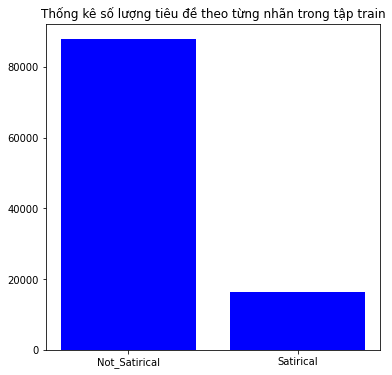

[87814, 16240] [8400, 8000]


In [134]:
#số lượng nhãn 0 và 1 trogn tập train
lst1 = [Counter(y_train)[0], Counter(y_train)[1]]
plt.figure(figsize = (6, 6))
marks = ["Not_Satirical", "Satirical"]
plt.bar(marks, lst1, color = "blue")
plt.title("Thống kê số lượng tiêu đề theo từng nhãn trong tập train")
plt.show()

print(lst1, lst2)

- tỷ lệ giữa nhãn 0 và 1 trong tập train rất chênh lệch theo

In [135]:
max = 0
sum = 0
for i in X_train:
  z = i.split()
  sum += len(z)
  if (len(z)>max):
    max = len(z)
print("Câu có độ dài lớn nhất: " + str(max))
print("Độ dài trung bình của các tiêu đề: " + str(sum/len(X_train)))

Câu có độ dài lớn nhất: 61
Độ dài trung bình của các tiêu đề: 12.428027754819613


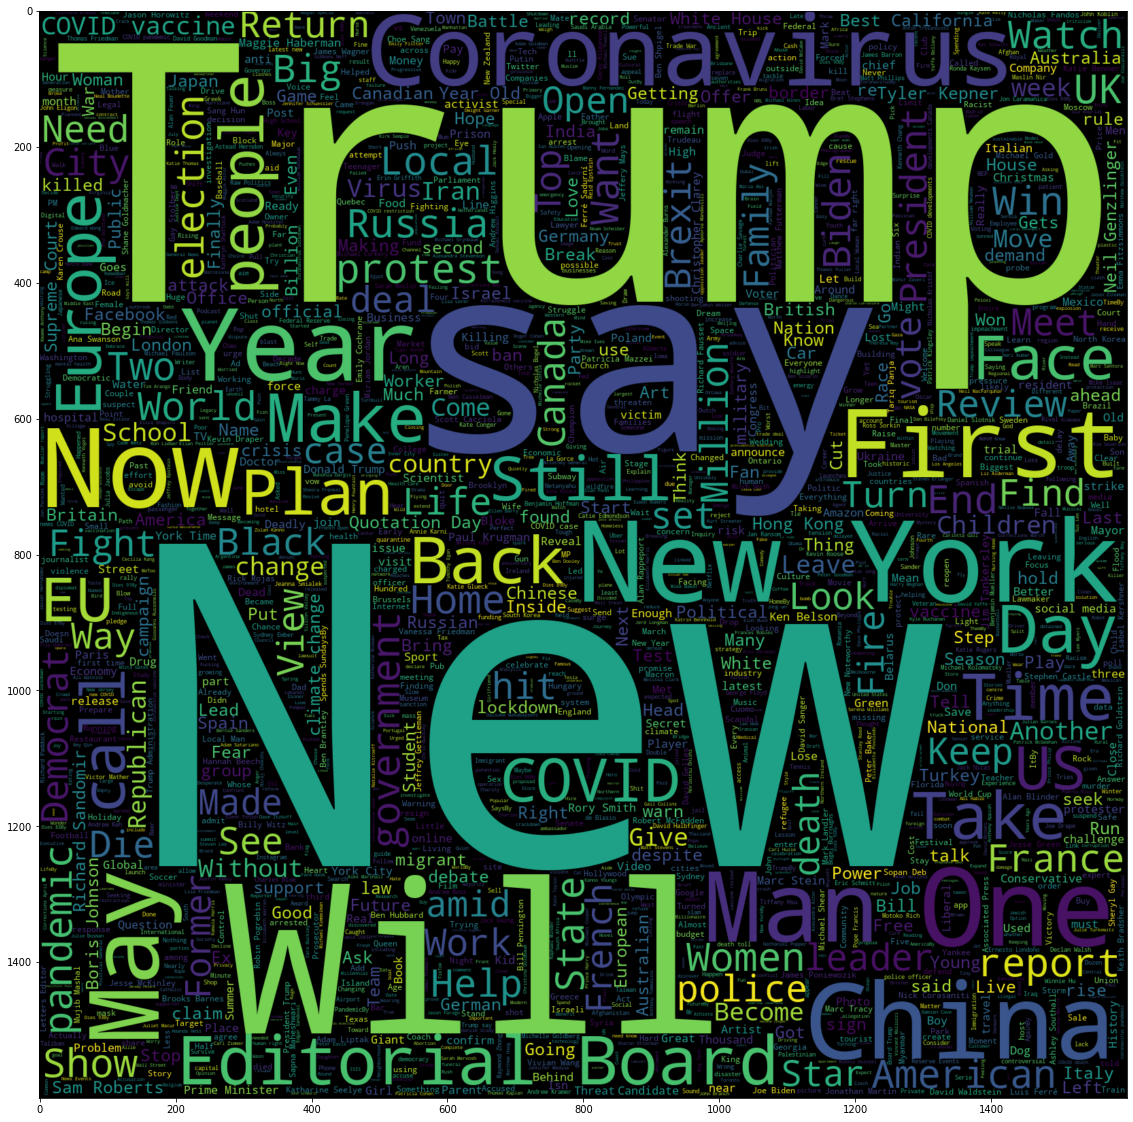

In [136]:
plt.figure(figsize = (20,20)) 
text = " ".join(review for review in X_train)
wc = WordCloud(max_words = 2000 , width = 1600 , height = 1600).generate(text)
plt.imshow(wc , interpolation = 'bilinear')

# Chuyển dữ liệu về vector đặc trưng

In [137]:
vocab_size = 60000 
embedding_dim = 6
max_length = 64

In [138]:

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_) #Tạo bộ từ vựng dựa trên tập train.

In [139]:
train_sequences = tokenizer.texts_to_sequences(X_train_) #chuyển từ headline thành list các số nguyên dựa trên vị trí trong bộ từ vựng
test_sequences = tokenizer.texts_to_sequences(X_test_)

In [140]:
print(X_train_[1])
train_sequences[1]

Two friends start a renewable revolution on their tiny remote island


[118, 979, 400, 7, 8074, 2895, 12, 68, 2046, 2284, 656]

In [141]:
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, truncating= "post", padding = "post") #chuyển các vector thành các vector có cùng độ dài
padded_test_sequences = pad_sequences(test_sequences, maxlen = max_length, truncating="post", padding = "post")

In [142]:
# trộn lại dữ liệu ngẫu nhiên
X_train, y_train = shuffle(padded_train_sequences, y_train, random_state=0) 
X_test, y_test = shuffle(padded_test_sequences, y_test, random_state=0)

##Huấn luyện mô hình
###Feature Engineering với Word2Vec
- Word2Vec = CBOW (continous bag of words) + Skip gram
- Điểm chung: được build dựa trên mạng neuron 3 lớp: Input Layer, Hidden Layer, Output Layer.
- Mục đích: Học các trọng số biểu diễn vector từ
- CBOW: dự đoán xác suất của một từ được đưa ra theo ngữ cảnh
- Skip gram: dự đoán ngữ cảnh của một từ đưa vào

In [143]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(layers.Conv1D(64, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy')

In [ ]:
history = model.fit(X_train, np.array(y_train), epochs=10)
# lưu lại model
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/saved_model1/my_model')

In [144]:
#dự đoán tập test
model  = tf.keras.models.load_model("/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/saved_model1/my_model")
predict = model.predict(padded_test_sequences)

In [145]:
lst = []
for i in predict:
  if (i<0.5):
    lst.append(0)
  else:
    lst.append(1)

In [146]:
def CM_plot(M):
    X = [i/np.sum(i) for i in M]
    plt.figure(figsize = (10,10))
    sns.heatmap(X,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not_Satiricle','Is_Satirical'] , yticklabels = ['Not_Satirical','Is_Satirical'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lst))

              precision    recall  f1-score   support

           0       0.51      0.63      0.56      8400
           1       0.48      0.36      0.41      8000

    accuracy                           0.50     16400
   macro avg       0.49      0.49      0.49     16400
weighted avg       0.49      0.50      0.49     16400



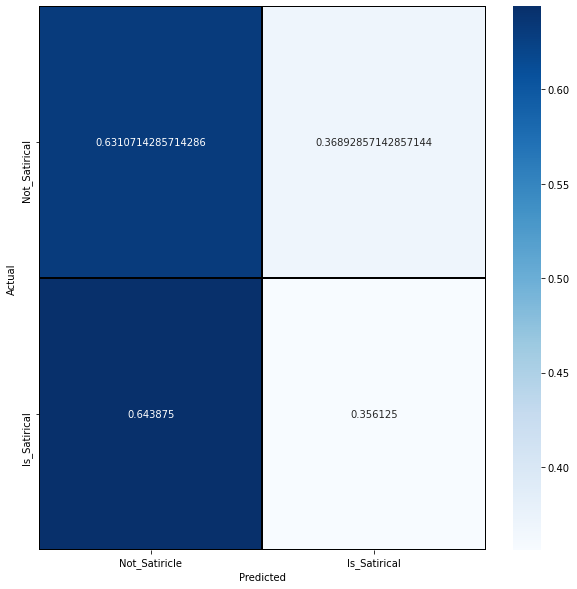

In [148]:
CM_plot(confusion_matrix(y_test, lst))

##Nhận xét: 
- Khả năng dự đoán đúng một bài báo châm biếm và không châm biếm thấp có thể  do số lượng giữa các nhãn trong tập bị mất cân bằng.
- Số lượng headline của nhãn 1 (bài báo châm biếm) thấp hơn rất nhiều so với số lượng headline nhãn 0 ( bài báo chính thống) tỷ lệ 1/5 rất chênh lệch
# Đề xuất sử dụng kĩ thuật smote để cân bằng lại dữ liệu giữa các nhãn



#Xử lý lại dữ liệu mất cân bằng
- Sử dụng kĩ thuật Smote


In [149]:
#lấy dữ liệu
X1_train,y1_train = read_file_train("not_Satirical")
X2_train,y2_train = read_file_train("Satirical")
X1_test, y1_test = read_file_test("not_Satirical")
X2_test, y2_test =read_file_test("Satirical")
X_train = X1_train + X2_train
y_train = y1_train + y2_train
X_test = X1_test + X2_test
y_test = y1_test + y2_test
print("số lượng tiêu đề trong tập train:" + str(len(X_train)))
print("số lượng tiêu đề trong tập test: " + str(len(X_test)))


số lượng tiêu đề trong tập train:104054
số lượng tiêu đề trong tập test: 16400


In [150]:
#tiền xử lý dữ liệu
X_train_ = normalize(X_train)
X_test_ = normalize(X_test)

In [151]:
# trích xuất đặc trưng
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_)
train_sequences = tokenizer.texts_to_sequences(X_train_)
test_sequences = tokenizer.texts_to_sequences(X_test_)
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, truncating= "post", padding = "post")
padded_test_sequences = pad_sequences(test_sequences, maxlen = max_length, truncating="post", padding = "post")
# trộn lại dữ liệu ngẫu nhiên
X_train, y_train = shuffle(padded_train_sequences, y_train, random_state=0)
X_test, y_test = shuffle(padded_test_sequences, y_test, random_state=0)

In [152]:
#Cân bằng lại dữ liệu
counter = Counter(y_train)
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({0: 87814, 1: 16240})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 43907, 1: 43907})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


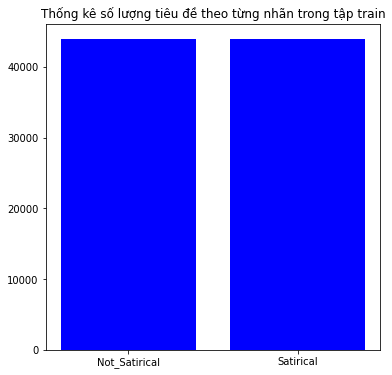

[43907, 43907] [8400, 8000]


In [153]:
#số lượng nhãn 0 và 1 trogn tập train
lst1 = [Counter(y_train)[0], Counter(y_train)[1]]
plt.figure(figsize = (6, 6))
marks = ["Not_Satirical", "Satirical"]
plt.bar(marks, lst1, color = "blue")
plt.title("Thống kê số lượng tiêu đề theo từng nhãn trong tập train")
plt.show()
print(lst1, lst2)

In [ ]:
#train lại model
history = model.fit(X_train, np.array(y_train), epochs=10)
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/saved_model2/my_model')

In [154]:
# dự đoán trên bộ test
model = tf.keras.models.load_model('/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/saved_model2/my_model')
predict = model.predict(padded_test_sequences)
lst = []
for i in predict:
  if (i<0.5):
    lst.append(0)
  else:
    lst.append(1)
print(classification_report(y_test, lst))

              precision    recall  f1-score   support

           0       0.50      0.21      0.29      8400
           1       0.49      0.79      0.60      8000

    accuracy                           0.49     16400
   macro avg       0.49      0.50      0.45     16400
weighted avg       0.50      0.49      0.44     16400



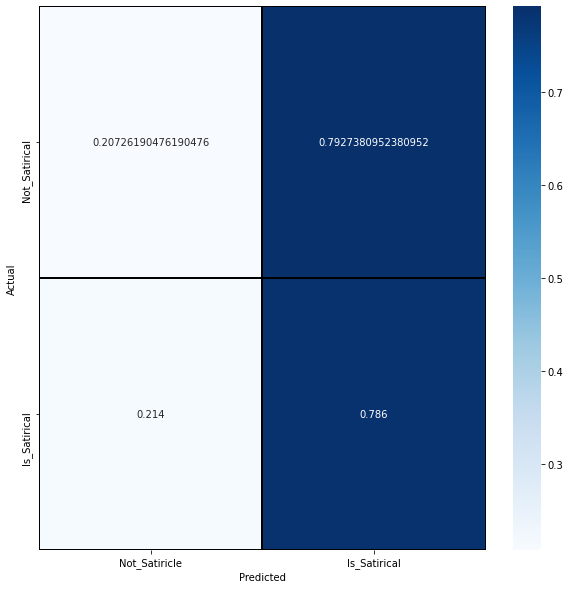

In [155]:
CM_plot(confusion_matrix(y_test, lst))

## Nhận xét:
- Sau khi cân bằng lại số lượng dữ liệu giữa các nhãn thì kết quả không đạt kết quả tốt hơn so với mô hình khi dữ liệu bị chênh lệch ban đầu
- Tỷ lệ dự đoán đúng với nhãn 0 thì thấp tuy nhiên đối với nhãn 1 thì tốt hơn.
- Để cải thiện mô hình tốt hơn nhóm tiếp tục thử nghiệm cải thiện mô hình bằng cách bổ sung dữ cho tập train.

In [156]:
def read_file_train_bonus(flag):
  if flag == 1:
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Bonus Not_Satirical/TheDailyBonet_1.csv"
    data =pd.read_csv(path)
    X_train = []
    y_train = []
    for i in range(len(data['headline'])):
      X_train.append(data['headline'][i])
      y_train.append(data['is_sarcastic'][i])
    return X_train, y_train
  elif flag == 2:
    path ="/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Bonus Not_Satirical/Sarcasm_1.json"
    data =pd.read_json(path)
    X_train = []
    y_train = []
    for i in range(len(data['headline'])):
      X_train.append(data['headline'][i])
      y_train.append(data['is_sarcastic'][i])
    return X_train, y_train
  elif flag == 3:
    path =  "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Bonus Not_Satirical/Trusted_0.json"
    data = pd.read_json(path)
    X_train = []
    y_train = []
    for i in range(len(data['headline'])):
      try:        
        y_train.append(int(data['is_sarcastic'][i]))
        X_train.append(data['headline'][i])
      except:
        z = 0
    return X_train, y_train
  elif flag==4:
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Bonus Not_Satirical/rochdaleherald.co.uk_1.csv"
    data= pd.read_csv(path)
    X_train = []
    y_train = []
    for i in range(len(data['headline'])):
      try:        
        y_train.append(int(data['is_sarcastic'][i]))
        X_train.append(data['headline'][i])
      except:
        z = 0
    return X_train, y_train
  else:
    path = "/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/Train/Bonus Not_Satirical/thedailymash.co.uk_1 (1).csv"
    data = pd.read_csv(path)
    X_train = []
    y_train = []
    for i in range(len(data['headline'])):
      try:        
        y_train.append(int(data['is_sarcastic'][i]))
        X_train.append(data['headline'][i])
      except:
        z = 0
    return X_train, y_train
  

In [157]:
X1_train,y1_train = read_file_train("not_Satirical")
print(Counter(y1_train))
X2_train,y2_train = read_file_train("Satirical")
print(Counter(y2_train))
X3_train, y3_train = read_file_train_bonus(1)
print(Counter(y3_train))
X4_train, y4_train = read_file_train_bonus(2)
print(Counter(y4_train))
X5_train, y5_train = read_file_train_bonus(3)
print(Counter(y5_train))
X6_train, y6_train = read_file_train_bonus(4)
print(Counter(y6_train))
X7_train, y7_train = read_file_train_bonus(5)
print(Counter(y7_train))

X1_test, y1_test = read_file_test("not_Satirical")
X2_test, y2_test =read_file_test("Satirical")

X_train = X1_train[:32000] + X2_train + X3_train+ X4_train+ X5_train + X6_train + X7_train
y_train = y1_train[:32000] + y2_train + y3_train+ y4_train + y5_train + y6_train + y7_train
X_test = X1_test + X2_test
y_test = y1_test + y2_test
print("số lượng tiêu đề trong tập train:" + str(len(X_train)))
print("số lượng tiêu đề trong tập test: " + str(len(X_test)))

Counter({0: 87814})
Counter({1: 16240})
Counter({1: 1756})
Counter({1: 29721})
Counter({0: 30901})
Counter({1: 14398})
Counter({1: 310})
số lượng tiêu đề trong tập train:125326
số lượng tiêu đề trong tập test: 16400


Counter({0: 62901, 1: 62425})


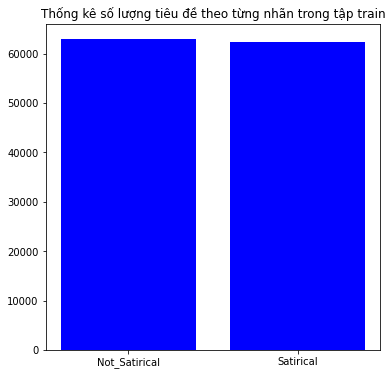

In [158]:
#số lượng nhãn 0 và 1 trogn tập train và tập test
lst1 = [Counter(y_train)[0], Counter(y_train)[1]]
lst2 = [Counter(y_test)[0], Counter(y_test)[1]]
print(Counter(y_train))
plt.figure(figsize = (6, 6))
marks = ["Not_Satirical", "Satirical"]
plt.bar(marks, lst1, color = "blue")
plt.title("Thống kê số lượng tiêu đề theo từng nhãn trong tập train")
plt.show()

In [159]:
#Tiền xử lý dữ liệu
X_train_ = normalize(X_train)
X_test_ = normalize(X_test)

In [160]:
# trích xuất đặc trưng
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train_)
test_sequences = tokenizer.texts_to_sequences(X_test_)
padded_train_sequences = pad_sequences(train_sequences, maxlen = max_length, truncating= "post", padding = "post")
padded_test_sequences = pad_sequences(test_sequences, maxlen = max_length, truncating="post", padding = "post")
# trộn lại dữ liệu ngẫu nhiên
X_train, y_train = shuffle(padded_train_sequences, y_train, random_state=0)
X_test, y_test = shuffle(padded_test_sequences, y_test, random_state=0)

In [161]:
print(len(X_train))
print(len(y_train))

125326
125326


In [ ]:
#train lại model
history = model.fit(X_train, np.array(y_train), epochs=10)
#lưu lại model
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/saved_model3/my_model')

In [163]:
from sklearn.metrics import classification_report
model = tf.keras.models.load_model("/content/gdrive/MyDrive/CS114 - Máy học/Dataset - Sarcasm detection/saved_model3/my_model")
predict = model.predict(X_train)
lst = []
for i in predict:
  if (i<0.5):
    lst.append(0)
  else:
    lst.append(1)
print(classification_report(y_train, lst))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     62901
           1       1.00      1.00      1.00     62425

    accuracy                           1.00    125326
   macro avg       1.00      1.00      1.00    125326
weighted avg       1.00      1.00      1.00    125326



In [164]:
# dự đoán trên bộ test
from sklearn.metrics import classification_report
predict = model.predict(X_test)
lst = []
for i in predict:
  if (i<0.5):
    lst.append(0)
  else:
    lst.append(1)
print(classification_report(y_test, lst))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      8400
           1       0.72      0.72      0.72      8000

    accuracy                           0.73     16400
   macro avg       0.73      0.73      0.73     16400
weighted avg       0.73      0.73      0.73     16400



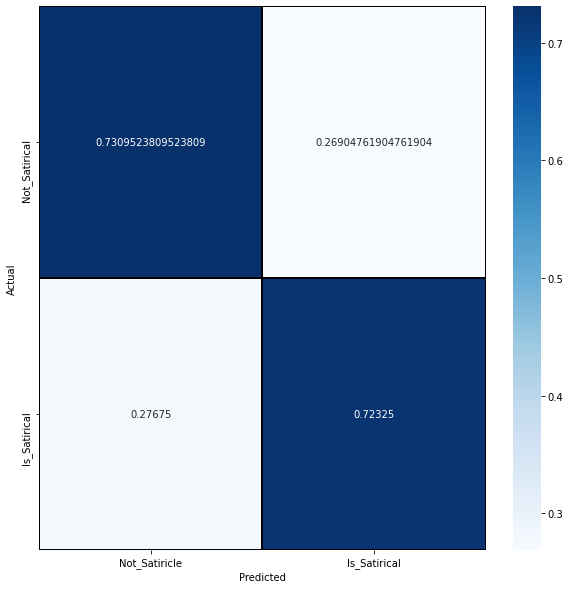

In [165]:
CM_plot(confusion_matrix(y_test, lst))

##Nhận xét:
- Sau khi bổ sung thêm dữ liệu train thì kết quả đã được cải thiện.
- Khả năng dự đoán đúng nhãn 0 và 1 đều trên 70% 
- 

## Nguồn tham khảo:
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- https://colab.research.google.com/github/hieubkset/Colab-Notebooks/blob/master/save_and_load.ipynb#scrollTo=NstL6zk_Ezg0
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://forum.machinelearningcoban.com/t/hoc-bieu-dien-ngon-ngu-cho-may-tinh/299


## sử dụng phương pháp rút trích đặc trưng TF-IDF


In [171]:
X1_train,y1_train = read_file_train("not_Satirical")
print(Counter(y1_train))
X2_train,y2_train = read_file_train("Satirical")
print(Counter(y2_train))
X3_train, y3_train = read_file_train_bonus(1)
print(Counter(y3_train))
X4_train, y4_train = read_file_train_bonus(2)
print(Counter(y4_train))
X5_train, y5_train = read_file_train_bonus(3)
print(Counter(y5_train))
X6_train, y6_train = read_file_train_bonus(4)
print(Counter(y6_train))
X7_train, y7_train = read_file_train_bonus(5)
print(Counter(y7_train))

X1_test, y1_test = read_file_test("not_Satirical")
X2_test, y2_test =read_file_test("Satirical")

X_train = X1_train[:32000] + X2_train + X3_train+ X4_train+ X5_train + X6_train + X7_train
y_train = y1_train[:32000] + y2_train + y3_train+ y4_train + y5_train + y6_train + y7_train
X_test = X1_test + X2_test
y_test = y1_test + y2_test
print("số lượng tiêu đề trong tập train:" + str(len(X_train)))
print("số lượng tiêu đề trong tập test: " + str(len(X_test)))

Counter({0: 87814})
Counter({1: 16240})
Counter({1: 1756})
Counter({1: 29721})
Counter({0: 30901})
Counter({1: 14398})
Counter({1: 310})
số lượng tiêu đề trong tập train:125326
số lượng tiêu đề trong tập test: 16400


In [172]:
#Tiền xử lý dữ liệu
X_train_ = normalize(X_train)
X_test_ = normalize(X_test)

In [173]:
#trích xuất đặc trưng bằng phương pháp TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names())

['00', '000', '00001', '0001', '0002', '000km', '000th', '001', '0010001001011100', '004', '007', '00pm', '01', '015', '02', '03', '036', '037', '04', '05', '053', '08', '088', '0ft', '10', '100', '1000', '1000km', '100b', '100bn', '100ft', '100k', '100kg', '100km', '100kms', '100m', '100th', '100x', '101', '102', '103', '104', '105', '1054', '106', '107', '108', '1080', '108k', '109', '1099', '10am', '10bn', '10cm', '10ft', '10k', '10kg', '10kgs', '10lbs', '10m', '10mil', '10min', '10mm', '10p', '10pm', '10s', '10th', '10x', '10yearchallenge', '10yo', '11', '110', '1100', '110k', '111', '112', '113', '113th', '114', '114m', '115', '116', '117', '118', '119', '11am', '11bn', '11k', '11m', '11pm', '11s', '11th', '12', '120', '1200', '120k', '120kg', '120m', '121', '122', '122bn', '122m', '123', '124', '1240', '125', '126', '127', '127k', '128', '129', '12992000000', '12am', '12bn', '12k', '12lbs', '12m', '12pm', '12s', '12th', '13', '130', '130cm', '130k', '130km', '130kmph', '131', '13

In [174]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [175]:
from sklearn.svm import LinearSVC

In [176]:
clf = LinearSVC(C = 1, tol = 5e-5)

In [177]:
clf.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=5e-05,
          verbose=0)

In [178]:
predict = clf.predict(X_test)

In [179]:
print(classification_report(y_test, lst))

              precision    recall  f1-score   support

           0       0.51      0.50      0.51      8400
           1       0.48      0.49      0.48      8000

    accuracy                           0.49     16400
   macro avg       0.49      0.49      0.49     16400
weighted avg       0.50      0.49      0.50     16400



## Nhận xét: 
- Sau khi thử nghiệm kết hợp giữa phương pháp trích xuất đặc trưng TF-IDF và mô hình máy học SVM thì cho kết quả thấp hơn so với phương pháp trích xuất đặc trưng Wordembedding và mô hình CNN.